# Vorticity
Plot vertical relative vorticity $v_x - u_y$

In [1]:
%matplotlib inline
import cosima_cookbook as cc
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
import psutil
import gc

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.


/home/156/aek156/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
# use with care - sometimes this apparently hangs
# cc.start_cluster()

In [3]:
# cc.build_index(careful=True)

In [4]:
# from joblib import Memory
# memory = Memory(cachedir='/g/data1/v45/cosima-cookbook/', verbose=0)

In [5]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
#     plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [6]:
clim_years = 20  # how many years to use for model climatology

In [7]:
# define start and end dates for all runs
tstart = pd.to_datetime('1996', format='%Y')
# tend = tstart + pd.DateOffset(years=10)

In [8]:
# location coords: [ minlon, maxlon, minlat, maxlat ]
# key names are used as filenames so should not have spaces
locations = { 
#               'EAC_ACC_SouthPacific': [140-360,240-360,-65,-20], 
# #               'EAC_ACC':             [140-360,190-360,-65,-20],
              'EAC':                     [145-360,175-360,-45,-20],
              'Kuroshio':                [125-360,155-360,25,50],
              'GulfStream':             [-85,-50,25,50],
              'Agulhas':                 [10,40,-45,-20]
    # TODO: ACC
}

In [76]:
ekey = '01deg'
expt = exptdata.exptdict[ekey]['expt']
time_units = exptdata.exptdict[ekey]['time_units']

vort = cc.get_nc_variable(expt,'rregionocean_daily_30m.nc', 'vorticity_z', 
                                   time_units = time_units, use_cache=True).isel(st_ocean_sub02=1)

vort_orig = vort

# concat duplicated data along eastern edge and tripole seam to avoid gaps in plots
# NB: don't flip data at tripole, as lon_t, lat_t are flipped below
vort = xr.concat([vort, vort.isel(xt_ocean_sub01=0)], dim='xt_ocean_sub01')
vort = xr.concat([vort, vort.isel(yt_ocean_sub01=-1)], dim='yt_ocean_sub01')

vortsnap = vort.isel(time=-1)

gridFileList = glob(os.path.join(exptdata.exptdict[ekey]['exptdir'], 'output*/ocean/ocean_grid.nc'))
gridFileList.sort()
ncFile = nc.Dataset(gridFileList[0],'r')
lon_t = ncFile.variables['geolon_t'][...]
lat_t = ncFile.variables['geolat_t'][...]
lon_t_orig = lon_t
lat_t_orig = lat_t
# concat duplicated data along eastern edge and reversed data along tripole seam to avoid gaps in plots
lon_t = np.ma.concatenate([lon_t, lon_t[:,0,None]+360], axis=1)
lat_t = np.ma.concatenate([lat_t, lat_t[:,0,None]], axis=1)
lon_t = np.ma.concatenate([lon_t, np.flip(lon_t[None,-1,:], axis=1)], axis=0)
lat_t = np.ma.concatenate([lat_t, np.flip(lat_t[None,-1,:], axis=1)], axis=0)

Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_rregionocean_daily_30m.nc_vorticity_z_None_None_None_False.pkl


In [92]:
np.array_equal(lat_t, joinseams(lat_t_orig))

True

In [94]:
np.array_equal(lon_t, joinseams(lon_t_orig, lon=True))

True

In [88]:
vort.isel(time=-1).identical(joinseams(vort_orig).isel(time=-1))

True

In [10]:
vortsnap

<xarray.DataArray 'vorticity_z' (yt_ocean_sub01: 2701, xt_ocean_sub01: 3601)>
dask.array<shape=(2701, 3601), dtype=float32, chunksize=(900, 1200)>
Coordinates:
    st_ocean_sub02  float64 29.45
    time            datetime64[ns] 2006-08-29T12:00:00
  * xt_ocean_sub01  (xt_ocean_sub01) float64 -279.9 -279.8 ... 79.95 -279.9
  * yt_ocean_sub01  (yt_ocean_sub01) float64 0.0 0.0 0.0 ... 89.94 89.98 89.98
Attributes:
    long_name:      vertical vorticity component: v_x - u_y
    units:          1/sec
    valid_range:    [-1000000.  1000000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [11]:
# make custom white-red-black-blue-white colormap instead of using cm.cm.curl
# see https://matplotlib.org/examples/pylab_examples/custom_cmap.html
colors = [(1,1,1), (1,0.5,0.5), (1,0,0), (0,0,0), (0,.4,1), (0.5,0.7,1), (1, 1, 1)]
vortcmap = LinearSegmentedColormap.from_list('my-list', colors, N=255)

In [12]:
vmax = 4e-5
levels = np.linspace(-vmax, vmax, 101)
cbar_scale_factor = 1e-5  # scaling factor for colorbar tick labels
# cbar_ticks = [ 0 if abs(v)<1e-9*vmax else v for v in levels[0::5] ]
cbar_ticks = np.linspace(-vmax, vmax, 9)
cbar_ticklabels = [ str(round(v/cbar_scale_factor,1)) for v in cbar_ticks ]

font = {'size':13}
tick_font=10

In [13]:
def plot_vort(lon_0=0, lat_0=0, zoom=4, date=None):
    '''
    Plot vorticity. lon_0 and lat_0 are centre of view.
    '''
    fig = plt.figure(figsize=(10,10))
    # NB: projection='stere' doesn't work - not all contour levels plotted
    m1 = Basemap(projection='ortho',lon_0=-105,lat_0=90,resolution=None)
    xhalfsize = m1.urcrnrx/2/zoom
    yhalfsize = m1.urcrnry/2/zoom
    m = Basemap(projection='ortho',lon_0=lon_0,lat_0=lat_0,resolution=None,
               llcrnrx=-xhalfsize,llcrnry=-yhalfsize,urcrnrx=xhalfsize,urcrnry=yhalfsize)
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    ax.axis('off') # hide axis frame
    x,y = m(*(lon_t, lat_t))
    vv = vort.sel(time=date, method='nearest')*np.sign(lat_t)
# TODO: also select spatial region to reduce memory load
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
#     m.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
#     m.drawmeridians(np.arange(-180.,180.,10.),labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
#     m.drawparallels(np.arange(-80.,81.,10.),color='white',linewidth=0.5)
#     m.drawmeridians(np.arange(-180.,180.,10.),color='white',linewidth=0.5)
    ctr = m.contourf(x, y, vv, levels=levels, cmap=vortcmap, extend='both')
    ctr.cmap.set_over(color='w', alpha=None)
    ctr.cmap.set_under(color='w', alpha=None)
#     cbar = m.colorbar(ctr, location = 'right', pad = "6%", shrink=0.8)

    cbar = m.colorbar(ctr, location='right') #, shrink=0.8, aspect=30)

    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_ticklabels)
    cbar.ax.tick_params(labelsize=tick_font)
    cbar.set_label('Sign(f) * relative vorticity at 30m ('+str(cbar_scale_factor)+' 1/s)',size=15)
    plt.title('Relative vorticity * sign(f) in '+exptdata.exptdict[ekey]['desc']+' at 30m', fontsize=18)
    plt.annotate(date.strftime('%d-%m-%Y'),(1,1.02),xycoords='axes fraction')
    
    del(vv)
    return fig

## Define camera path
Repeatedly circumnavigate globe with increasing latitude.

0.2 degree shift/frame at 25fps would do a lap in 72s with 1800 frames

With zoom=4, view covers about 25deg in latitude, so to cover 180deg would need 180/25 = about 7 laps.

So a total of about 12600 frames, over 6Gb of images... infeasible!

If frames are daily it will be about 5 years per lap and about 6 years in total.

Movie run time about 100sec.

20 days/sec might be a bit fast? but 20fps a bit jerky?

looks like 1 deg steps are too jerky.

try 0.25 deg steps


### a more modest proposal

zoom=2: camera view of ~60deg in latitude

0.5deg shift/frame and 1 day per 0.5 deg => 720 frames & ~2yr per lap

180/60=3 so 3 laps => 2160 frames, ~1Gb, ~6yr

86sec at 25fps

In [30]:
def camera(frame):
    '''
    Defines camera trajectory.
    
    Returns longitude, latitude and zoom for a given frame (frame can be real).
    '''
#     lat = -70+25*frame/10/360
#     lon = (-30-frame/10)%360
#     zoom = 4

    lat = -90+60*frame/2/360
    lon = (-30-frame/2)%360
    zoom = 2

    return lat, lon, zoom

In [31]:
# for frame in range(0,365*6*10,2):
#     date = tstart + pd.DateOffset(days=int(frame/5))

for frame in range(0,360*7):
    date = tstart + pd.DateOffset(days=int(frame))
    lat, lon, zoom = camera(frame)
    outname = NOSYNC+'vortmovie/'+ekey+'_vorticity_'+\
            str(frame).zfill(5)+'_'+\
            date.strftime('%Y_%m_%d')+'_'+\
            str(round(lon,2)).zfill(7)+'_'+str(round(lat,2)).zfill(7)+'_'+str(zoom).zfill(2)
    if os.path.exists(os.path.join(figdir, outname+'.png')):
        print('Skipping ' + outname + ' (file exists)')
    else:
        print('memory available:', psutil.virtual_memory().available/1024/1024, 'Mb')
        print('Doing ' + outname)
        fig = plot_vort(lon_0=lon, lat_0=lat, zoom=zoom, date=date) 
        plt.savefig(outname+'.png',dpi=110, bbox_inches="tight")
#         fig.clf()
        plt.close()
        gc.collect() # to avoid running out of memory....? doesn't make a difference?

Skipping NOSYNC/vortmovie/01deg_vorticity_00000_1996_01_01_00330.0_-0090.0_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00001_1996_01_02_00329.5_-089.92_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00002_1996_01_03_00329.0_-089.83_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00003_1996_01_04_00328.5_-089.75_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00004_1996_01_05_00328.0_-089.67_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00005_1996_01_06_00327.5_-089.58_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00006_1996_01_07_00327.0_-0089.5_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00007_1996_01_08_00326.5_-089.42_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00008_1996_01_09_00326.0_-089.33_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00009_1996_01_10_00325.5_-089.25_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00010_1996_01_11_00325.0_-089.17_02 (f

Skipping NOSYNC/vortmovie/01deg_vorticity_00330_1996_11_26_00165.0_-0062.5_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00331_1996_11_27_00164.5_-062.42_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00332_1996_11_28_00164.0_-062.33_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00333_1996_11_29_00163.5_-062.25_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00334_1996_11_30_00163.0_-062.17_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00335_1996_12_01_00162.5_-062.08_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00336_1996_12_02_00162.0_-0062.0_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00337_1996_12_03_00161.5_-061.92_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00338_1996_12_04_00161.0_-061.83_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00339_1996_12_05_00160.5_-061.75_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00340_1996_12_06_00160.0_-061.67_02 (f

Skipping NOSYNC/vortmovie/01deg_vorticity_00774_1998_02_13_00303.0_-0025.5_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00775_1998_02_14_00302.5_-025.42_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00776_1998_02_15_00302.0_-025.33_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00777_1998_02_16_00301.5_-025.25_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00778_1998_02_17_00301.0_-025.17_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00779_1998_02_18_00300.5_-025.08_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00780_1998_02_19_00300.0_-0025.0_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00781_1998_02_20_00299.5_-024.92_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00782_1998_02_21_00299.0_-024.83_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00783_1998_02_22_00298.5_-024.75_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_00784_1998_02_23_00298.0_-024.67_02 (f

Skipping NOSYNC/vortmovie/01deg_vorticity_01235_1999_05_20_00072.5_0012.92_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01236_1999_05_21_00072.0_00013.0_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01237_1999_05_22_00071.5_0013.08_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01238_1999_05_23_00071.0_0013.17_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01239_1999_05_24_00070.5_0013.25_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01240_1999_05_25_00070.0_0013.33_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01241_1999_05_26_00069.5_0013.42_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01242_1999_05_27_00069.0_00013.5_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01243_1999_05_28_00068.5_0013.58_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01244_1999_05_29_00068.0_0013.67_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01245_1999_05_30_00067.5_0013.75_02 (f

Skipping NOSYNC/vortmovie/01deg_vorticity_01709_2000_09_05_00195.5_0052.42_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01710_2000_09_06_00195.0_00052.5_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01711_2000_09_07_00194.5_0052.58_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01712_2000_09_08_00194.0_0052.67_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01713_2000_09_09_00193.5_0052.75_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01714_2000_09_10_00193.0_0052.83_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01715_2000_09_11_00192.5_0052.92_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01716_2000_09_12_00192.0_00053.0_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01717_2000_09_13_00191.5_0053.08_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01718_2000_09_14_00191.0_0053.17_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_01719_2000_09_15_00190.5_0053.25_02 (f

Skipping NOSYNC/vortmovie/01deg_vorticity_02095_2001_09_26_00002.5_0084.58_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_02096_2001_09_27_00002.0_0084.67_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_02097_2001_09_28_00001.5_0084.75_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_02098_2001_09_29_00001.0_0084.83_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_02099_2001_09_30_00000.5_0084.92_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_02100_2001_10_01_00000.0_00085.0_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_02101_2001_10_02_00359.5_0085.08_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_02102_2001_10_03_00359.0_0085.17_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_02103_2001_10_04_00358.5_0085.25_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_02104_2001_10_05_00358.0_0085.33_02 (file exists)
Skipping NOSYNC/vortmovie/01deg_vorticity_02105_2001_10_06_00357.5_0085.42_02 (f

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


memory available: 16709.001953125 Mb
Doing NOSYNC/vortmovie/01deg_vorticity_02161_2001_12_01_00329.5_0090.08_02


ValueError: lat_0 must be between -90.000000 and 90.000000 degrees

<Figure size 720x720 with 0 Axes>

In [ ]:
STOPHERE

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


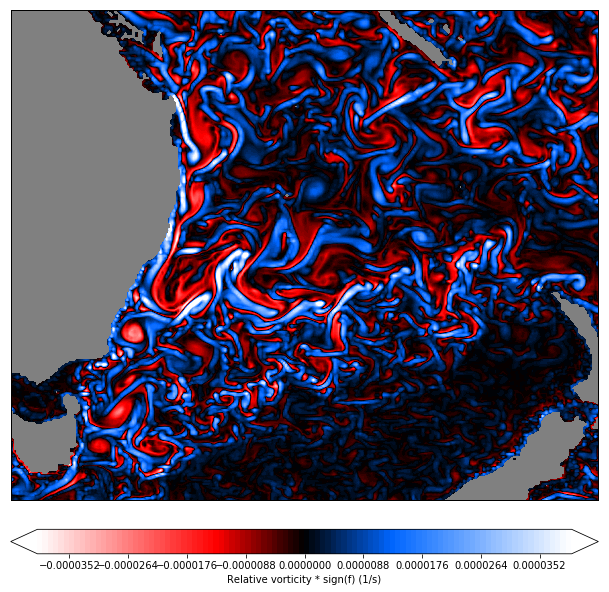

In [16]:
for locname,loc in locations.items():
    fig = plt.figure(figsize=(16,10))
#     m = Basemap(projection='mbtfpq', lon_0 = -100, resolution='l')
    m = Basemap(projection='cyl', lon_0 = -100, resolution='l')
    x,y = m(*(lon_t, lat_t))
    vv = vortsnap*np.sign(y) # NB: sets vv=0 on equator
    # m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(x, y, vv, levels=levels, cmap=vortcmap, extend='both')
    # ctr = m.contourf(x, y, vv) #, levels=levels, cmap=cm.cm.curl)
    ctr.cmap.set_over(color='w', alpha=None)
    ctr.cmap.set_under(color='w', alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Relative vorticity * sign(f) (1/s)',size=tick_font)
    plt.xlim(loc[0],loc[1])
    plt.ylim(loc[2],loc[3])
    savefigure(locname)
    break


# parallels = np.arange(-80.,81,10.)
# m.drawparallels(parallels,color='white',linewidth=0.5)
# meridians = np.arange(0.,351.,30.)
# m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)

In [ ]:
ekey = '01deg'
plot_vort(lat_0=-65, zoom=2, date=tstart)


In [ ]:
frame=2.5*720
lat, lon, zoom=camera(frame)
plot_vort(lon_0=lon, lat_0=lat, zoom=zoom, date=tstart + pd.DateOffset(days=int(frame)))
plt.savefig('test110dpi-5.png',dpi=110, bbox_inches="tight")

In [ ]:
STOPHERE

In [ ]:
# plot vorticity globally
vmax = 1e-4
fig = plt.figure(figsize=(16,10))
vv = vortsnap
cax = plt.pcolormesh(vv.xt_ocean_sub01, vv.yt_ocean_sub01, vv, 
                    shading='flat', cmap=vortcmap, vmin=-vmax, vmax=vmax)
plt.title(exptdata.exptdict[ekey]['desc'], fontsize=12)
fig.colorbar(cax,shrink=0.8,label='Vertical relative vorticity (1/s)',extend='both')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#     savefigure(locname+'_clim')

In [ ]:
# plot vorticity in each location
vmax = 1e-4
ncols = 2
nrows = math.ceil((len(locations))/ncols)
i = 0
for locname,loc in locations.items():
    i = i + 1
    fig = plt.figure(figsize=(16,10))
    ax = fig.add_subplot(ncols, nrows, i)
    print(loc)
    vv = vortsnap.sel(yt_ocean_sub01=slice(loc[2],loc[3])) #.sel(xt_ocean_sub01=slice(loc[0],loc[1]))
    cax = ax.pcolormesh(vv.xt_ocean_sub01, vv.yt_ocean_sub01, vv, 
                        shading='flat', cmap=vortcmap, vmin=-vmax, vmax=vmax)
    plt.title(locname + ', ' + exptdata.exptdict[ekey]['desc'], fontsize=12)
    plt.xlim(loc[0],loc[1])
    plt.ylim(loc[2],loc[3])
    fig.colorbar(cax,shrink=0.8,label='Vertical relative vorticity (1/s)',extend='max')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#     savefigure(locname+'_clim')

In [ ]:
STOPHERE
# code below is from pv.ipynb

In [ ]:
# load model speed climatologies and snapshots
speeds = copy.deepcopy(exptdata.exptdict)  # this will store speed fields under the same keys as exptdata.exptdict
for ekey in speeds.keys():
     if ekey=='01deg': # for testing
        expt = speeds[ekey]['expt']
        print(ekey)

        ## Load PV from expt
        pvall = cc.get_nc_variable(expt, 'ocean.nc', 'vert_pv', time_units = 'days since 1900-01-01')
        pvall = pvall.sel(st_ocean=slice(0,1000)).mean('st_ocean')

        tend = pvall['time'].data[-1]  # final time in model data
        tstart = pvall['time'].data[0]  # first time in model data
        tclimend = tend  # end of climatology  --  NB: type should be numpy.datetime64 but might be <class 'datetime.datetime'>
        if isinstance(tclimend, np.datetime64):
            tclimstart = pd.to_datetime(tclimend) - pd.DateOffset(years=clim_years) + pd.DateOffset(days=1)  # start of climatology
            tclimstart = tclimstart.to_datetime64()  # match to time type
        else:
            tclimstart = tclimend - pd.DateOffset(years=clim_years) + pd.DateOffset(days=1)  # start of climatology

#         pv = pvall.isel(st_ocean=0).sel(time=slice(tclimstart,tclimend)).mean('time')
#         pv_snap = pvall.isel(st_ocean=0).isel(time=-1)
        pv = pvall.sel(time=slice(tclimstart,tclimend)).mean('time')
        pv_snap = pvall.isel(time=-1)


        speeds[ekey]['pv'] = pv
        speeds[ekey]['pv_snap'] = pv_snap
        speeds[ekey]['tend'] = tend
        speeds[ekey]['tstart'] = tstart
        speeds[ekey]['tclimend'] = tclimend
        speeds[ekey]['tclimstart'] = tclimstart
        del(pvall)

In [ ]:
# plot obs and all model mean speeds in each location
vmax = 1e-8
ncols = 2
nrows = math.ceil((len(speeds)+1)/ncols)
for locname,loc in locations.items():
    fig = plt.figure(figsize=(16,10))
    for i, ekey in enumerate(speeds.keys()):
        if ekey=='01deg': # for testing
            ax = fig.add_subplot(ncols, nrows, i+2)
            speed = speeds[ekey]['pv'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
            cax = ax.pcolormesh(speed.xt_ocean, speed.yt_ocean, speed, 
                                shading='flat', cmap=cm.cm.curl, vmin=-vmax, vmax=vmax)
            plt.title(speeds[ekey]['model'], fontsize=12)
            plt.xlim(loc[0],loc[1])
            plt.ylim(loc[2],loc[3])
            fig.colorbar(cax,shrink=0.8,label='Vertical Ertel PV (UNITS???)',extend='max')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#     savefigure(locname+'_clim')

In [ ]:
# plot obs and all model mean speeds in each location
vmax = 1e-8
ncols = 2
nrows = math.ceil((len(speeds)+1)/ncols)
for locname,loc in locations.items():
    fig = plt.figure(figsize=(16,10))
    for i, ekey in enumerate(speeds.keys()):
        if ekey=='01deg': # for testing
            ax = fig.add_subplot(ncols, nrows, i+2)
            speed = speeds[ekey]['pv_snap'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
            cax = ax.pcolormesh(speed.xt_ocean, speed.yt_ocean, speed, 
                                shading='flat', cmap=cm.cm.curl, vmin=-vmax, vmax=vmax)
            plt.title(speeds[ekey]['model'], fontsize=12)
            plt.xlim(loc[0],loc[1])
            plt.ylim(loc[2],loc[3])
            fig.colorbar(cax,shrink=0.8,label='Vertical Ertel PV (UNITS???)',extend='max')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#     savefigure(locname+'_clim')

In [ ]:
# plot obs and all model snapshot speeds in each location

# TODO: get 1-day snapshots from ice?

vmax = 0.8
ncols = 2
nrows = math.ceil((len(speeds)+1)/ncols)
for locname,loc in locations.items():
    fig = plt.figure(figsize=(16,10))
    fig.suptitle('Observed surface current climatology and model snapshots - TODO: get 1-day snapshots from ice', fontsize=14)
    oloc = copy.copy(loc)
    # BUG: this probably won't work for regions that straddle 180E
    if oloc[0]<-180:
        oloc[0] = oloc[0]+360
    if oloc[1]<-180:
        oloc[1] = oloc[1]+360
    obs_speed_loc = obs_speed.sel(latitude=slice(oloc[2],oloc[3])).sel(longitude=slice(oloc[0],oloc[1]))
    ax = fig.add_subplot(ncols, nrows, 1)
    cax = ax.pcolormesh(obs_speed_loc.longitude, obs_speed_loc.latitude, np.swapaxes(obs_speed_loc,0,1), 
                        shading='flat', cmap=cm.cm.thermal, vmin=0, vmax=vmax)
    plt.title('Drifter observations (Laurindo et al., 2017)', fontsize=12)
    plt.xlim(oloc[0],oloc[1])
    plt.ylim(oloc[2],oloc[3])
    fig.colorbar(cax,shrink=0.8,label='Speed (m/s)',extend='max')

    for i, ekey in enumerate(speeds.keys()):
        ax = fig.add_subplot(ncols, nrows, i+2)
        speed = speeds[ekey]['speed_snap'].sel(yu_ocean=slice(loc[2],loc[3])).sel(xu_ocean=slice(loc[0],loc[1]))
        cax = ax.pcolormesh(speed.xu_ocean, speed.yu_ocean, speed, 
                            shading='flat', cmap=cm.cm.thermal, vmin=0, vmax=vmax)
        plt.title(speeds[ekey]['model'], fontsize=12)
        plt.xlim(loc[0],loc[1])
        plt.ylim(loc[2],loc[3])
        fig.colorbar(cax,shrink=0.8,label='Speed (m/s)',extend='max')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    savefigure(locname+'_snap')